In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py

In [17]:
n_side = 512
n_pix = hp.nside2npix(n_side)

def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

In [18]:
index_dir = "/Users/arne/data/DESY3/public/DESY3_indexcat.h5"
with h5py.File(index_dir, "r") as f:
    # indices_metacal = f["index/metacal/select"][:]

    # after Marco's suggestion
    indices_metacal = f["index/select"][:]
    indices_maglim = f["index/maglim/select"][:]

dnf_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1_DNF.h5"
with h5py.File(dnf_dir, "r") as f:
    # z_metacal = f["catalog/unsheared/zmean_sof"][:][indices_metacal]
    z_maglim = f["catalog/unsheared/zmean_sof"][:][indices_maglim]

assert len(indices_metacal) == 100204026

# redshift range
# z_mask_metacal = (0.0 < z_metacal) & (z_metacal < 2.0)
z_mask_maglim = (0.2 < z_maglim) & (z_maglim < 1.05)

# indices_metacal = indices_metacal[z_mask_metacal]
indices_maglim = indices_maglim[z_mask_maglim]

index_intersect = np.intersect1d(indices_metacal, indices_maglim)

# TODO it should only be 1e8 Metacal galaxies, there are 23 Million too many here
print(f"total metacal {len(indices_metacal):.4e}")
print(f"total maglim  {len(indices_maglim):.4e}")

print(f"intersection  {len(index_intersect):.4e}")
print(f"\nMaglim galaxies in Metacal {100*len(index_intersect)/len(indices_maglim):.4f}%")
print(f"Metacal galaxies in Maglim {100*len(index_intersect)/len(indices_metacal):.4f}%")

total metacal 1.0020e+08
total maglim  1.0717e+07
intersection  9.6749e+06

Maglim galaxies in Metacal 90.2799%
Metacal galaxies in Maglim 9.6552%


In [19]:
gold_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1.h5"
with h5py.File(gold_dir, "r") as f:
    gold_ra = f["catalog/gold/ra"][:]
    gold_dec = f["catalog/gold/dec"][:]

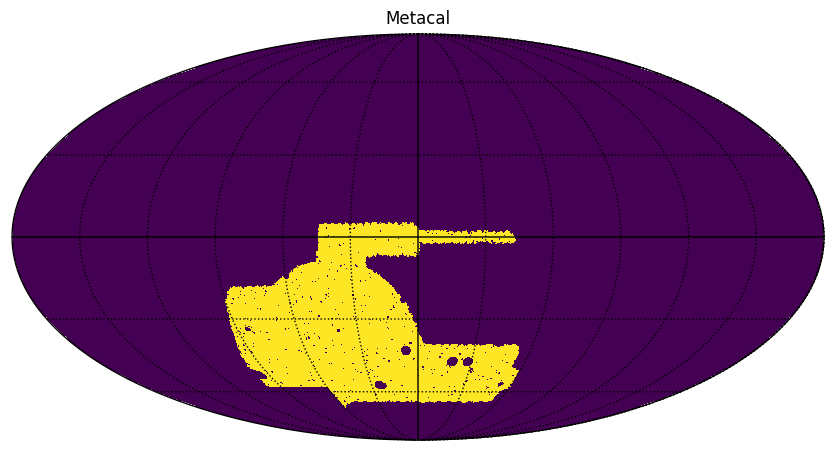

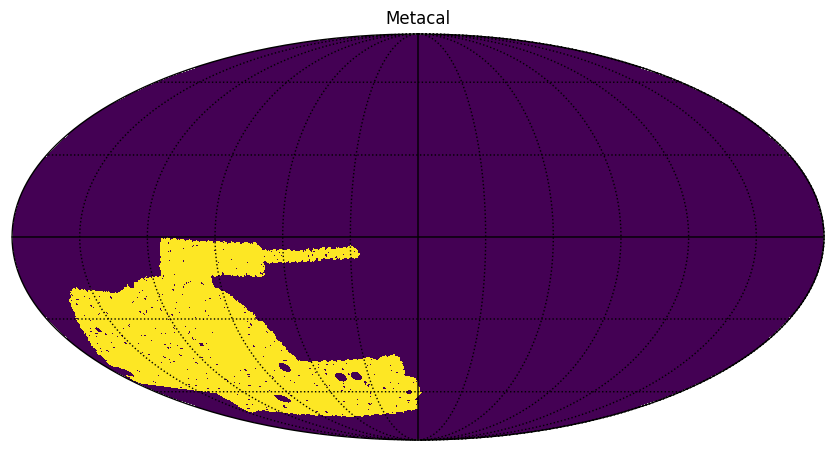

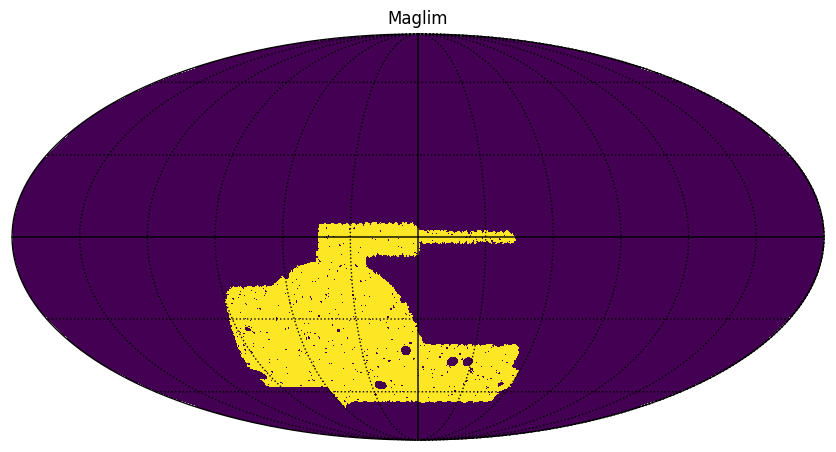

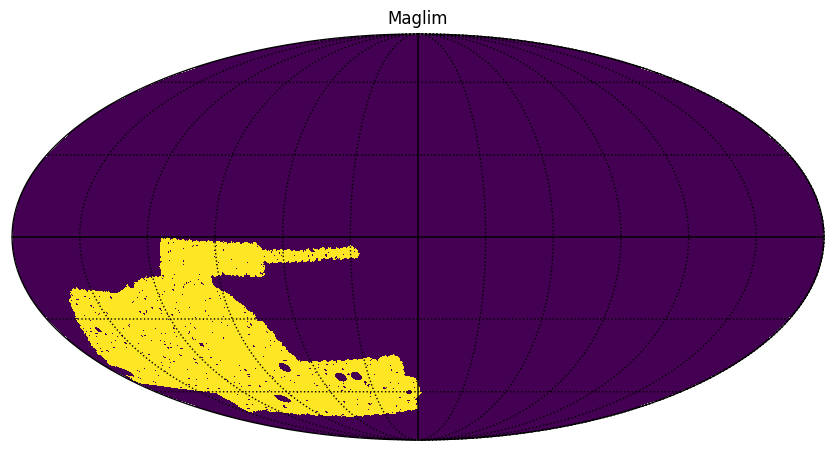

In [20]:
for indices, sample in zip([indices_metacal, indices_maglim], ["Metacal", "Maglim"]):
    ra = gold_ra[indices]
    dec = gold_dec[indices]

    theta = np.pi/2 - np.radians(dec)
    phi = np.radians(ra)
    vec = hp.ang2vec(theta=theta, phi=phi)

    # original
    pix = hp.ang2pix(n_side, theta, phi)
    mask = np.zeros(n_pix, dtype=bool)
    mask[pix] = True
    hp.mollview(mask, cbar=False, title=sample)
    hp.graticule()
    
    # rotated
    y_rot = get_rot_y(-0.125)
    # y_rot.shape = (3,3), rot_vec.shape = (n_galaxies, 3)
    rot_vec = np.dot(y_rot, vec.T)

    z_rot = get_rot_z(-1.22)
    # z_rot.shape = (3,3), rot_vec.shape = (3, n_galaxies)
    rot_vec = np.dot(z_rot, rot_vec)

    rot_pix = hp.vec2pix(n_side, rot_vec[0], rot_vec[1], rot_vec[2])
    rot_mask = np.zeros(n_pix, dtype=bool)
    rot_mask[rot_pix] = True
    hp.mollview(rot_mask, cbar=False, title=sample)
    hp.graticule()
